In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
import matplotlib.colors as mcolors
plt.rcParams["figure.figsize"] = (10,10)
tf.__version__

'2.2.0'

In [2]:
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

In [3]:
df = pd.read_csv('../../Data/Flujo2.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1

# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Social Externo']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)
df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)

# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])

print('Media', np.array(df.groupby('_dimension').count().NumRespuesta).mean())
print('STD', np.std(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos', np.sum(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos min ', np.min(df.groupby('_dimension').count().NumRespuesta))
print('Cant. datos max ', np.max(df.groupby('_dimension').count().NumRespuesta))

Media 5002.714285714285
STD 3612.4135467375627
Cant. datos 70038
Cant. datos min  1928
Cant. datos max  16273


# Busqueda de Hyperparametros

In [ ]:
def gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y, paramsEmbedding, paramsLSTM, num_clases, optimizer, batch_size, epoch):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = paramsEmbedding['input_dim'],  output_dim = paramsEmbedding['output_dim'], input_shape=(tensor_X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = paramsLSTM['units'],
                                   activation = paramsLSTM['activation'],
                                   dropout = paramsLSTM['dropout'],
                                   recurrent_dropout = paramsLSTM['recurrent_dropout']))
    
    model.add(tf.keras.layers.Dense(units = num_clases ,activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose = 0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions )
    print(medidas[0])
    return [test_acurracy, test_loss, medidas, paramsEmbedding, paramsLSTM, optimizer, batch_size, epoch]


def grid_lstm(data_x, data_y, input_dim, output_dim_embe, units_lstm, activ_lstm, drop_lstm, rec_drop_lstm, num_clases, optimizers, batch_size_, epochs):
    X, test_x, y, test_y = train_test_split(data_x, data_y, test_size = 0.1, random_state = 0)
    tensor_X      = tf.convert_to_tensor(list(X))
    tensor_test_x = tf.convert_to_tensor(list(test_x))
    tensor_y      = tf.convert_to_tensor(list(y))
    tensor_test_y = tf.convert_to_tensor(list(test_y))
    resultados = []
    for output_dim in output_dim_embe:
        for units in units_lstm:
            for activ in activ_lstm:
                for drop in drop_lstm:
                    for rec_drop in rec_drop_lstm:
                        for optimizer in optimizers:
                            for batch_size in batch_size_:
                                for epoch in epochs:
                                    resultados.append( gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y,  {'input_dim': input_dim, 'output_dim':output_dim}, 
                                                    {'units':units,'activation':activ,'dropout':drop, 'recurrent_dropout':rec_drop},
                                                   num_clases, optimizer, batch_size, epoch))
    return resultados

output = grid_lstm(data_x = X_completo,
          data_y = y_completo,
          input_dim = len(vocabulary)+1,
          num_clases = len(list_dimensions),
          output_dim_embe = [60, 90],
          units_lstm = [60, 90],
          activ_lstm = ['tanh', 'relu'],
          drop_lstm = [0.3,0.5,0.7],
          rec_drop_lstm = [0.3,0.5,0.7],
          optimizers = ['rmsprop','adam'],
          batch_size_ = [20, 40],
          epochs = [6,8]
         )


# K-Means

In [4]:
epoch = 6
batch_size = 40
optimizer = 'rmsprop'
recurrent_dropout = 0.7
dropout = 0.3
activation_lstm = 'relu'
lstm_units = 90
ouput_dim_embedding = 90

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    tensor_X      = tf.convert_to_tensor(list(X_completo[valores_entrenamiento]))
    tensor_test_x = tf.convert_to_tensor(list(X_completo[valores_testeo]))
    tensor_y      = tf.convert_to_tensor(list(y_completo[valores_entrenamiento]))
    tensor_test_y = tf.convert_to_tensor(list(y_completo[valores_testeo]))
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, 
                                        output_dim = ouput_dim_embedding,
                                        input_shape=(X_completo.shape[1],)))
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   activation=activation_lstm,
                                   dropout = dropout,
                                   recurrent_dropout = recurrent_dropout))
    model.add(tf.keras.layers.Dense(units=num_classes,
                                    activation='sigmoid'))
    model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose=0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions)
    resultados.append([test_loss, test_acurracy, medidas])
    
model.save('../Modelos/Flujo2/model_soce.h5')
#model_ = tf.keras.models.load_model('complete_social_ext.h5')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [5]:
print("loss mean",np.array([res[0] for res in resultados]).mean())
print("acurracy mean",np.array([res[1] for res in resultados]).mean())
print("media precision",np.array([np.array([res[2][0][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media recall",np.array([np.array([res[2][1][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media fscore",np.array([np.array([res[2][2][i] for res in resultados]).mean() for i in range(num_classes)]).mean())
print("media support",np.array([np.array([res[2][3][i] for res in resultados]).mean() for i in range(num_classes)]).mean())

loss mean 1.2914158582687378
acurracy mean 0.5764156520366669
media precision 0.6213866668404879
media recall 0.5916943205096131
media fscore 0.5998462541549607
media support 500.27142857142854


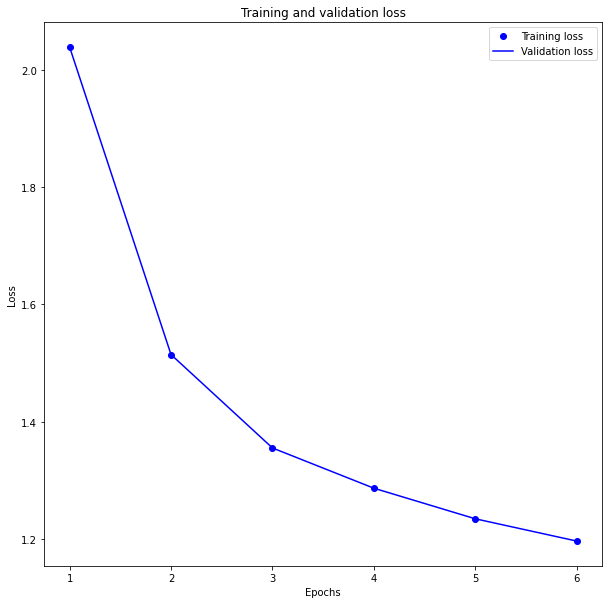

In [6]:
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../Imagenes/SOCE/T&V_loss_SOCE_2.png")

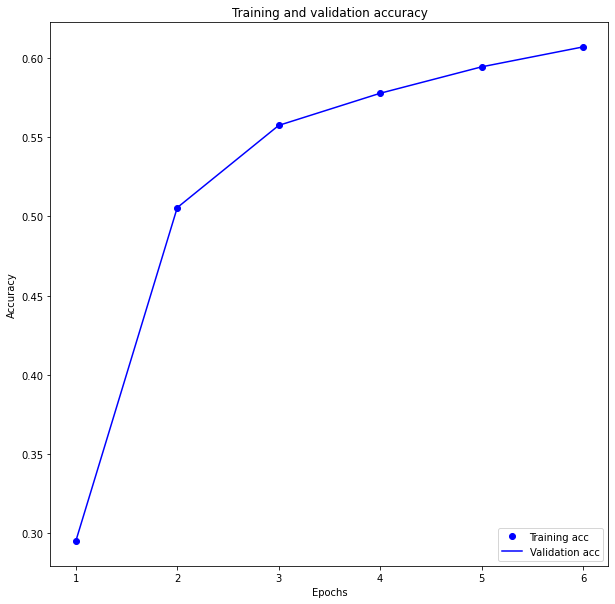

In [7]:
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("../Imagenes/SOCE/T&V_acc_SOCE_2.png")

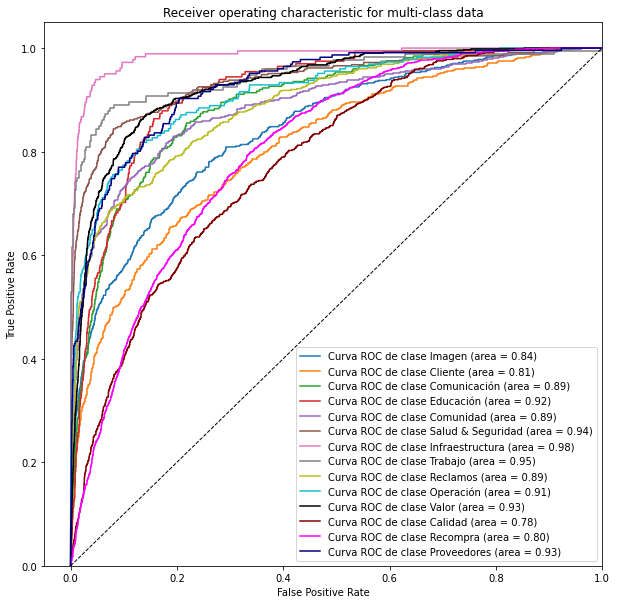

In [21]:
plt.clf() 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_test_bin = label_binarize(y_completo[valores_testeo], classes=range(num_classes))
y_predic_bin = model.predict(tensor_test_x)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_predic_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
dict_colors = list(mcolors.TABLEAU_COLORS.keys()) + ['#000000','#800000', '#FF00FF','#000080', '#00FFFF']
colors = cycle(dict_colors)
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='Curva ROC de clase {0} (area = {1:0.2f})'
             ''.format(list_dimensions[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig("../Imagenes/SOCE/ROC_SOCE_2.png")